## 모델링 준비

In [1]:
# 라이브러리
from google.cloud import storage
import io
import pandas as pd
import gcsfs
import os

import json
import matplotlib.pyplot as plt
import seaborn as sns

### 테이블 불러오기

In [2]:
# 서비스 계정 키 경로
key_path = '/Users/bettertospeak/Desktop/sprint/advance_pj/sprintda07-hyunseung-b549fc3c2f43.json'

# gcsfs 파일시스템 객체
fs = gcsfs.GCSFileSystem(token=key_path)

# 와일드카드로 GCS 파일 리스트 받기
file_list = fs.glob('gs://sprintda07-hyunseung/dataset/votes/accounts_*.parquet')
print("찾은 파일들:", file_list)

# 파일별 DataFrame을 저장할 딕셔너리
votes_ac = {}

# 각 파일 읽어서 개별 저장
for file_path in file_list:
    with fs.open(file_path, 'rb') as f:
        df = pd.read_parquet(f, engine='pyarrow')
        file_key = os.path.basename(file_path).replace('.parquet', '')  # 파일명만 키로 사용
        votes_ac[file_key] = df
        print(f"✅ {file_key} → shape: {df.shape}")

찾은 파일들: ['sprintda07-hyunseung/dataset/votes/accounts_attendance.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_blockrecord.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_failpaymenthistory.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_friendrequest.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_group.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_nearbyschool.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_paymenthistory.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_pointhistory.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_school.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_timelinereport.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_user.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_user_contacts.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_userquestionrecord.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_userwithdraw.parquet']
✅ accounts_attendance → shape: (349637, 3)
✅ 

In [3]:
# polls

file_list = fs.glob('gs://sprintda07-hyunseung/dataset/votes/polls_*.parquet')

votes_po = {}

# 각 파일 읽어서 개별 저장
for file_path in file_list:
    with fs.open(file_path, 'rb') as f:
        df = pd.read_parquet(f, engine='pyarrow')
        file_key = os.path.basename(file_path).replace('.parquet', '')  # 파일명만 키로 사용
        votes_po[file_key] = df
        print(f"✅ {file_key} → shape: {df.shape}")

✅ polls_question → shape: (5025, 3)
✅ polls_questionpiece → shape: (1265476, 5)
✅ polls_questionreport → shape: (51424, 5)
✅ polls_questionset → shape: (158384, 6)
✅ polls_usercandidate → shape: (4769609, 4)


In [4]:
# hackle_properties
gcs_path = 'gs://sprintda07-hyunseung/dataset/hackle/hackle_properties.parquet'

try:
    with fs.open(gcs_path, 'rb') as f:
        hackle_properties = pd.read_parquet(f)
    print(f"데이터 크기: {hackle_properties.shape}")
    # print(hackle_properties.head())
except Exception as e:
    print(f"오류: {e}")

데이터 크기: (525350, 8)


In [5]:
# hackle_events
gcs_path = 'gs://sprintda07-hyunseung/dataset/hackle/hackle_events.parquet'

try:
    with fs.open(gcs_path, 'rb') as f:
        hackle_events = pd.read_parquet(f)
    print(f"데이터 크기: {hackle_events.shape}")
except Exception as e:
    print(f"오류: {e}")

데이터 크기: (11441319, 11)


### 테이블 꺼내고 기간 필터링

In [6]:
# 8/7 테이블 불러오기 (이거 시간있을때 자동화좀... 보기 너무 안좋아)
accounts_user = votes_ac['accounts_user'].copy()
accounts_attendance = votes_ac['accounts_attendance'].copy()
accounts_blockrecord = votes_ac['accounts_blockrecord'].copy()
accounts_paymenthistory = votes_ac['accounts_paymenthistory'].copy()
polls_questionreport = votes_po['polls_questionreport'].copy()

In [7]:
# accounts_user 
# gender, group_id 결측치 제거 : 3건 제거
accounts_user = accounts_user.dropna()

# staff인 건 제거 : 1건 제거 (staff 3명인데 2명이 gender 결측치 있었음)
accounts_user = accounts_user[accounts_user['is_staff'] != 1]

In [8]:
# 필터링 기간
dfs = [('accounts_user', accounts_user), ('accounts_blockrecord', accounts_blockrecord), 
       ('accounts_paymenthistory', accounts_paymenthistory), 
       ('polls_questionreport', polls_questionreport)]

start_date = pd.to_datetime("2023-05-13")
end_date   = pd.to_datetime("2023-08-31")

for name, df in dfs:
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    filtered_df = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
    globals()[name] = filtered_df.reset_index(drop=True)

### 파생변수 생성 및 중복행 제거

In [9]:
# 출석일수 attendance_cnt
accounts_attendance['attendance_cnt'] = accounts_attendance['attendance_date_list'].apply(lambda x: len(json.loads(x)))

# 차단한 유저 수 block_cnt
accounts_blockrecord['block_cnt'] = accounts_blockrecord.groupby('user_id')['block_user_id'].transform('count')

# 상품 구매 횟수 pay_cnt
accounts_paymenthistory['pay_cnt'] = accounts_paymenthistory.groupby('user_id')['productId'].transform('count')

In [11]:
# hackle 집계
merged_ck = pd.merge(hackle_events, hackle_properties, on='session_id', how='left')
merged_ck = merged_ck.dropna()
unique_merged = merged_ck.drop_duplicates(subset='user_id')

In [12]:
unique_merged.columns

Index(['event_id', 'event_datetime', 'event_key', 'session_id', 'id_x',
       'item_name', 'page_name', 'friend_count', 'votes_count',
       'heart_balance', 'question_id', 'id_y', 'user_id', 'language', 'osname',
       'osversion', 'versionname', 'device_id'],
      dtype='object')

In [15]:
# 집계된 테이블들 한 번 저장
user = accounts_user.copy()
attendance = accounts_attendance.copy()
blockrecord = accounts_blockrecord.copy()
paymenthis = accounts_paymenthistory.copy()

In [16]:
# 중복행 제거
for df in [blockrecord, paymenthis]:
    df.drop_duplicates(subset=['user_id'], inplace=True)

In [27]:
df_numeric = unique_merged[unique_merged['user_id'].apply(lambda x: str(x).isdigit())].copy()
df_numeric['user_id'] = df_numeric['user_id'].astype(int)

df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38979 entries, 24 to 27324915
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        38979 non-null  object        
 1   event_datetime  38979 non-null  datetime64[ms]
 2   event_key       38979 non-null  object        
 3   session_id      38979 non-null  object        
 4   id_x            38979 non-null  object        
 5   item_name       38979 non-null  object        
 6   page_name       38979 non-null  object        
 7   friend_count    38979 non-null  float64       
 8   votes_count     38979 non-null  float64       
 9   heart_balance   38979 non-null  float64       
 10  question_id     38979 non-null  float64       
 11  id_y            38979 non-null  int64         
 12  user_id         38979 non-null  int64         
 13  language        38979 non-null  object        
 14  osname          38979 non-null  object        
 15  osv

### 테이블 병합

In [35]:
# 기준 테이블 id → user_id 변경
user = user.rename(columns={'id': 'user_id'})

# 병합할 테이블, 조인 키, 가져올 컬럼 지정
tables_to_merge = [
    (blockrecord, 'user_id', ['block_cnt']),
    (paymenthis, 'user_id', ['pay_cnt']),
    (attendance, 'user_id', ['attendance_cnt']),
    (df_numeric, 'user_id', ['friend_count', 'votes_count', 'heart_balance'])
    # (questionset, 'user_id', ['questionset_cnt']),
    # (questionrcd, 'user_id', ['vote_cnt']),
]

for df, key, cols in tables_to_merge:
    # 필요한 컬럼만 선택
    temp = df[[key] + cols].drop_duplicates(subset=[key])

    # key가 'user_id'가 아니면 통일
    if key != 'user_id':
        temp = temp.rename(columns={key: 'user_id'})

    # 이미 user에 존재하는 컬럼 제거 (중복 방지)
    duplicate_cols = set(temp.columns) & set(user.columns) - {'user_id'}
    if duplicate_cols:
        user = user.drop(columns=duplicate_cols)

    # 병합
    user = user.merge(temp, on='user_id', how='left')

# 결측치는 0으로 채우기 (숫자 컬럼만)
num_cols = user.select_dtypes(include=['number']).columns
user[num_cols] = user[num_cols].fillna(0)

# 결과 확인
print(user.head())

   user_id gender  point  is_push_on ban_status  report_count  alarm_count  \
0  1106970      F   3260           1          N             0            1   
1  1189921      F   2055           1          N             0            0   
2  1189924      M   1469           1          N             0            1   
3  1189925      M     42           1          N             0            0   
4  1189926      M    210           1          N             1            0   

   pending_chat  pending_votes  block_cnt  pay_cnt  attendance_cnt  \
0             0             29        0.0      0.0               2   
1             0              0        0.0      0.0               3   
2             0            184        0.0      1.0               1   
3             0              0        0.0      0.0               4   
4             0              1        0.0      0.0              17   

   friend_count  votes_count  heart_balance  
0           0.0          0.0            0.0  
1           0.0   

In [36]:
# 테이블 병합 후 처리

# 1) pending_chat -1인 4건 제거
user = user[user['pending_chat'] != -1]

# 2) 미출석 유저 제거 => 미투표, 질문미생성 미삭제
user = user[user['attendance_cnt'] != 0] # 미출석 160278건

In [39]:
# 안 쓸 컬럼 제거
user = user.drop(columns=['gender'])

* 마스터에서 비활성 유저 제거(출석 안함, 투표 안함) => 서비스 핵심 기능을 사용하지 않은 유저로 정의
1. 출석 일수 0일
    - accounts_attendance[accounts_attendance['attendance_cnt'] == 0]
2. 투표 횟수 0회
    - user[user['votes_count'] == 0]

In [72]:
user.describe()

,user_id,point,is_push_on,report_count,alarm_count,pending_chat,pending_votes,block_cnt,pay_cnt,attendance_cnt,friend_count,votes_count,heart_balance
count,1.946300e+05,1.946300e+05,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000
mean,1.396109e+06,2.017939e+03,0.862303,0.040271,0.807101,0.117402,55.969722,0.032621,0.232385,7.084175,4.501146,18.757889,230.296773
std,1.124904e+05,2.279115e+04,0.344583,0.428920,1.045207,4.162461,99.623391,0.316609,0.868036,9.339533,17.024037,81.691257,1360.834406
min,1.106970e+06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.300632e+06,4.210000e+02,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,1.403246e+06,1.138000e+03,1.000000,0.000000,1.000000,0.000000,9.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000
75%,1.494990e+06,2.614000e+03,1.000000,0.000000,1.000000,0.000000,67.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000
max,1.580265e+06,9.988541e+06,1.000000,71.000000,201.000000,1801.000000,2744.000000,39.000000,60.000000,310.000000,445.000000,2655.000000,208894.000000


In [74]:
user = user[user['votes_count'] != 0]

## 모델링

### 변수 상태 확인
1. 변수 간 다중공선성 확인
2. 변수 분포 확인
3. 이상치 확인

In [75]:
user.columns

Index(['user_id', 'point', 'is_push_on', 'ban_status', 'report_count',
       'alarm_count', 'pending_chat', 'pending_votes', 'block_cnt', 'pay_cnt',
       'attendance_cnt', 'friend_count', 'votes_count', 'heart_balance'],
      dtype='object')

In [76]:
user.shape

(17091, 14)

In [77]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 연속형 변수만
X = user[['point', 'report_count', 'alarm_count', 'pending_chat', 'pending_votes',
          'block_cnt', 'pay_cnt', 'attendance_cnt', 'friend_count', 'votes_count', 'heart_balance']] 

# 상수항 추가 (VIF 계산시 필요)
X_with_const = sm.add_constant(X)

# VIF 계산
vif_df = pd.DataFrame()
vif_df["variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X_with_const.values, i+1)  # const 제외
                 for i in range(len(X.columns))]

print(vif_df)


          variable       VIF
0            point  5.726570
1     report_count  2.929610
2      alarm_count  1.032843
3     pending_chat  2.986156
4    pending_votes  1.238511
5        block_cnt  1.002433
6          pay_cnt  1.018484
7   attendance_cnt  1.517638
8     friend_count  1.355679
9      votes_count  1.623336
10   heart_balance  4.959625


In [78]:
# 범주형 잠시 제거 
test = user.drop(columns=['ban_status', 'is_push_on'])

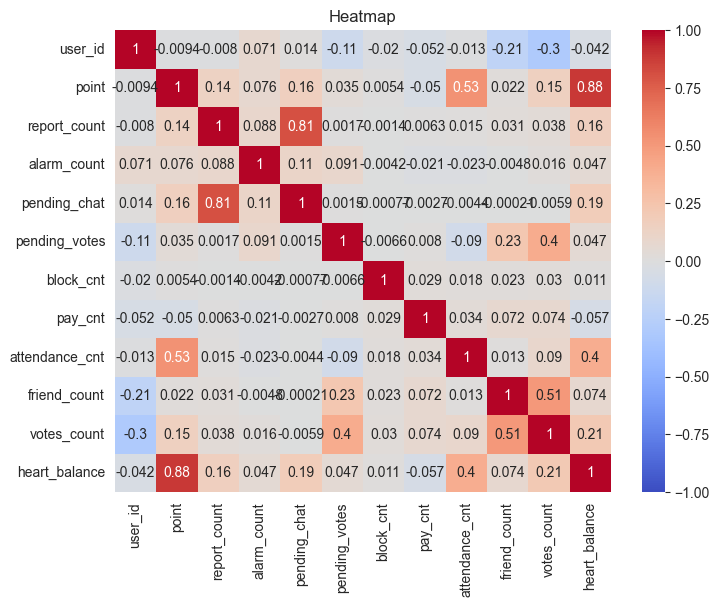

In [79]:
# 변수 간 상관계수 행렬 계산
corr_matrix = test.corr()

# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Heatmap')
plt.show()

### 모델링 전 전처리
1. user_id 제거
2. 스케일링

In [53]:
# 라이브러리
import numpy as np
from sklearn.cluster import (KMeans, DBSCAN)
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)

In [80]:
# master 원본 보존
cleaned = user.copy()

In [82]:
# user_id 제거
cleaned = cleaned.drop(columns=['user_id'])

# gender, ban_status 원핫 인코딩
cleaned = pd.get_dummies(cleaned, columns=['ban_status'])

# 로그 변환 (count 변수들에 대해서)

log_vars = [
    'point', 'report_count', 'alarm_count', 'pending_chat', 'pending_votes',
          'block_cnt', 'pay_cnt', 'attendance_cnt', 'friend_count', 'votes_count', 'heart_balance'
]

# 로그 변환
cleaned[log_vars] = cleaned[log_vars].apply(lambda x: np.log1p(x))

# 정규화
ss = StandardScaler()
scaled_df = pd.DataFrame(
    ss.fit_transform(cleaned),
    columns=cleaned.columns
)

KeyError: "['user_id'] not found in axis"

1. 차원축소 전

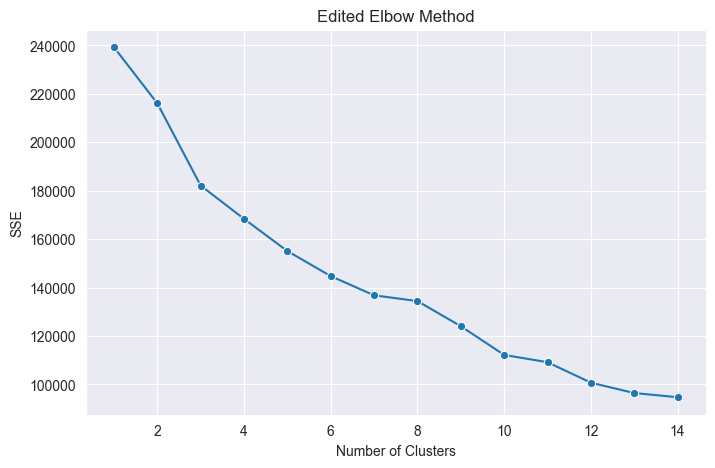

In [83]:
inertias = []

for k in range(1, 15):
    model = KMeans(n_clusters=k, random_state=123)
    model.fit(scaled_df)
    inertias.append(model.inertia_)

# k값에 따른 inertia값 시각화
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 15), y=inertias, marker='o')
plt.title('Edited Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [84]:
kmeans_data = scaled_df.copy() # 라벨용 원본 복제

# 모델 생성 및 클러스터 수 설정
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_df) # 학습
labels = kmeans.predict(scaled_df)

# 시각화 대비
kmeans_data['labels'] = kmeans.predict(scaled_df)

# 클러스터별 개수 확인
pd.Series(labels).value_counts().sort_index()

0    5929
1    5839
2    5090
3     233
Name: count, dtype: int64

In [85]:
final_model = kmeans_data.copy()
final_model.groupby('labels').mean().T

labels,0,1,2,3
point,-0.581319,0.915050,-0.373558,0.021745
is_push_on,0.084777,-0.017614,-0.070621,-0.173093
report_count,0.088856,0.010105,-0.112547,-0.055643
alarm_count,0.055011,-0.018034,-0.040589,-0.061206
pending_chat,0.034474,0.064690,-0.114433,0.001496
pending_votes,0.563496,-0.123828,-0.496660,-0.385991
block_cnt,0.003200,0.037259,-0.049690,0.070373
pay_cnt,0.320609,-0.184770,-0.155513,-0.130726
attendance_cnt,-0.302045,0.590941,-0.331939,0.128272
friend_count,0.559909,0.184051,-0.862680,-0.014292


2. 차원 축소 후

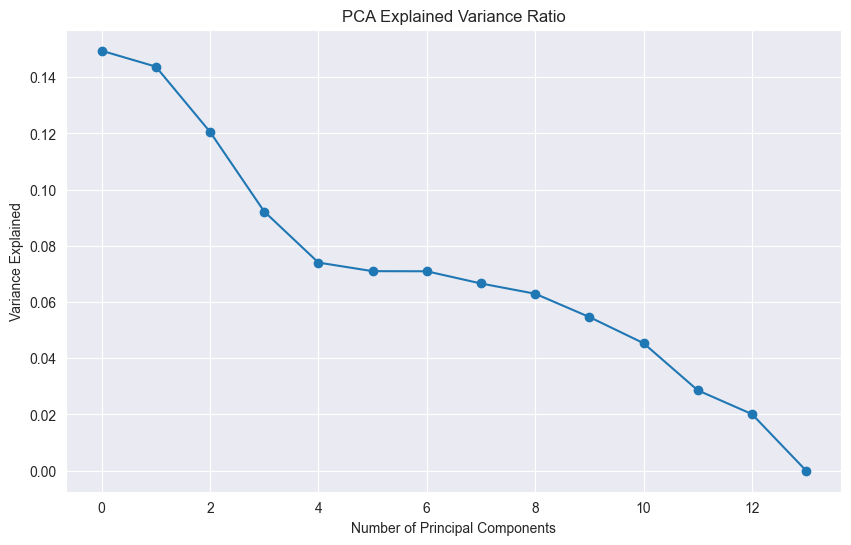

In [86]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
scaled_data_pca = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(scaled_data_pca)

# Scree Plot
num_components = len(pca.explained_variance_ratio_)

x = np.arange(num_components)
var = pca.explained_variance_ratio_

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(x, var, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('PCA Explained Variance Ratio')
plt.show()

In [87]:
X = scaled_df.copy()

pca = PCA(n_components=2)
x_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(x_pca, columns=['PC1', 'PC2'])

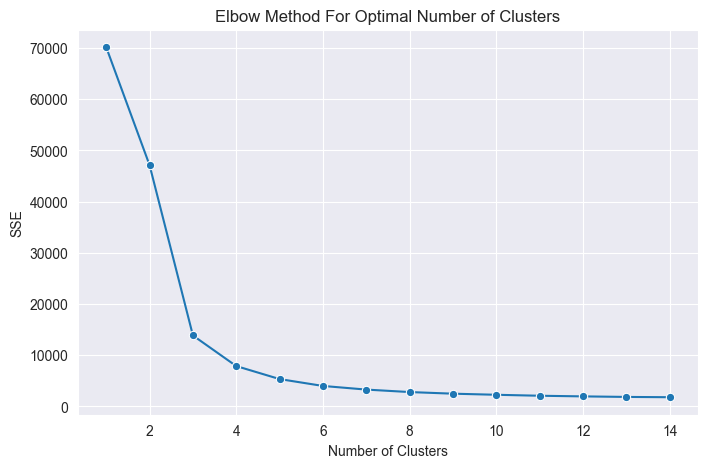

In [88]:
# 최적의 k 찾기 위한 elbow method 시각화
inertias = []

for k in range(1, 15):
    model = KMeans(n_clusters=k, random_state=123)
    model.fit(pca_df)
    inertias.append(model.inertia_)

# k값에 따른 inertia값 시각화
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 15), y=inertias, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [89]:
kmeans_data = scaled_df.copy() # 라벨용 원본 복제

# 모델 생성 및 클러스터 수 설정
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_df) # 학습
labels = kmeans.predict(pca_df)

# 시각화 대비
kmeans_data['labels'] = kmeans.predict(pca_df)

# 클러스터별 개수 확인
pd.Series(labels).value_counts().sort_index()

0    4340
1    4937
2     233
3    7581
Name: count, dtype: int64

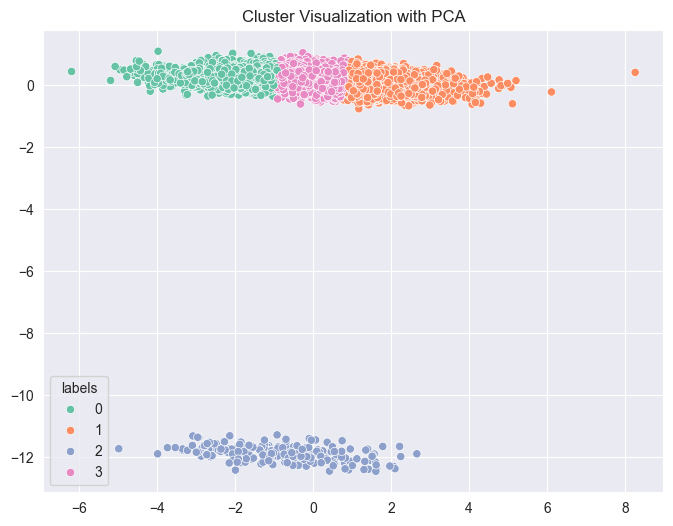

In [90]:
X_numeric = kmeans_data.drop(columns=['labels'])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numeric)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_data['labels'], palette='Set2')
plt.title('Cluster Visualization with PCA')
plt.show()

In [91]:
final_model = kmeans_data.copy()
final_model.groupby('labels').mean().T

labels,0,1,2,3
point,-0.841585,0.932588,0.021745,-0.126207
is_push_on,-0.027122,0.026443,-0.173093,0.003626
report_count,-0.118965,0.145924,-0.055643,-0.025215
alarm_count,-0.106184,0.101610,-0.061206,-0.003502
pending_chat,-0.149640,0.198956,0.001496,-0.043947
pending_votes,-0.355686,0.300604,-0.385991,0.019725
block_cnt,-0.051675,0.058830,0.070373,-0.010892
pay_cnt,0.100905,-0.104053,-0.130726,0.014014
attendance_cnt,-0.475817,0.527006,0.128272,-0.074749
friend_count,-0.685538,0.505801,-0.014292,0.063505


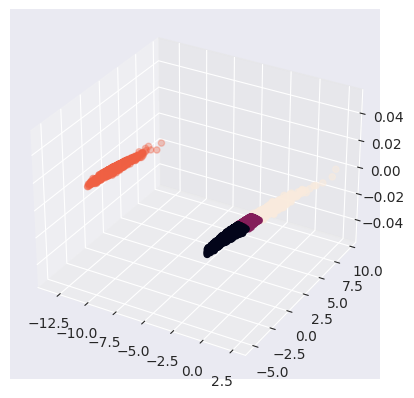

In [71]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], c=labels)

In [92]:
import pandas as pd

# df: feature dataframe, labels: 클러스터 라벨
cluster_means = kmeans_data.groupby(labels).mean()
cluster_diff = cluster_means.max() - cluster_means.min()
important_features = cluster_diff.sort_values(ascending=False)
print(important_features)

ban_status_N      8.623558
ban_status_W      8.623558
labels            3.000000
heart_balance     1.935880
point             1.774173
votes_count       1.541642
friend_count      1.191339
attendance_cnt    1.002823
pending_votes     0.686595
pending_chat      0.348596
report_count      0.264889
pay_cnt           0.231631
alarm_count       0.207793
is_push_on        0.199537
block_cnt         0.122048
dtype: float64


In [ ]:
import pandas as pd

# 영향도 시리즈
importance = pd.Series({
ban_status_N      9.146457,
ban_status_W      9.089282,
labels            3.000000
pending_votes     1.749816
alarm_count       1.581247
attendance_cnt    1.434014
ban_status_RB     0.973478
pay_cnt           0.542617
point             0.518009
pending_chat      0.470725
is_push_on        0.282717
ban_status_NB     0.264930
block_cnt         0.198074
report_count      0.127858
vote_cnt          0.042934
})

# 변수 그룹핑
grouped = {
    'ban_status': ['ban_status_N','ban_status_W','ban_status_RB','ban_status_NB'],
}

# 합치기
grouped_importance = {}
for g, cols in grouped.items():
    grouped_importance[g] = importance[cols].sum()

# 나머지 개별 변수
others = [col for col in importance.index if not any(col in v for v in grouped.values())]
for col in others:
    grouped_importance[col] = importance[col]

# 정렬
grouped_importance = pd.Series(grouped_importance).sort_values(ascending=False)
print(grouped_importance)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1466167827.py, line 5)

In [74]:
import numpy as np
from sklearn.metrics import silhouette_score

# 샘플링 (최대 10,000개)
sample_idx = np.random.choice(len(pca_df), size=10000, replace=False)

# .iloc로 행 선택
sil_score = silhouette_score(pca_df.iloc[sample_idx], np.array(labels)[sample_idx])

print(f"Silhouette Score: {sil_score:.3f}")


Silhouette Score: 0.526


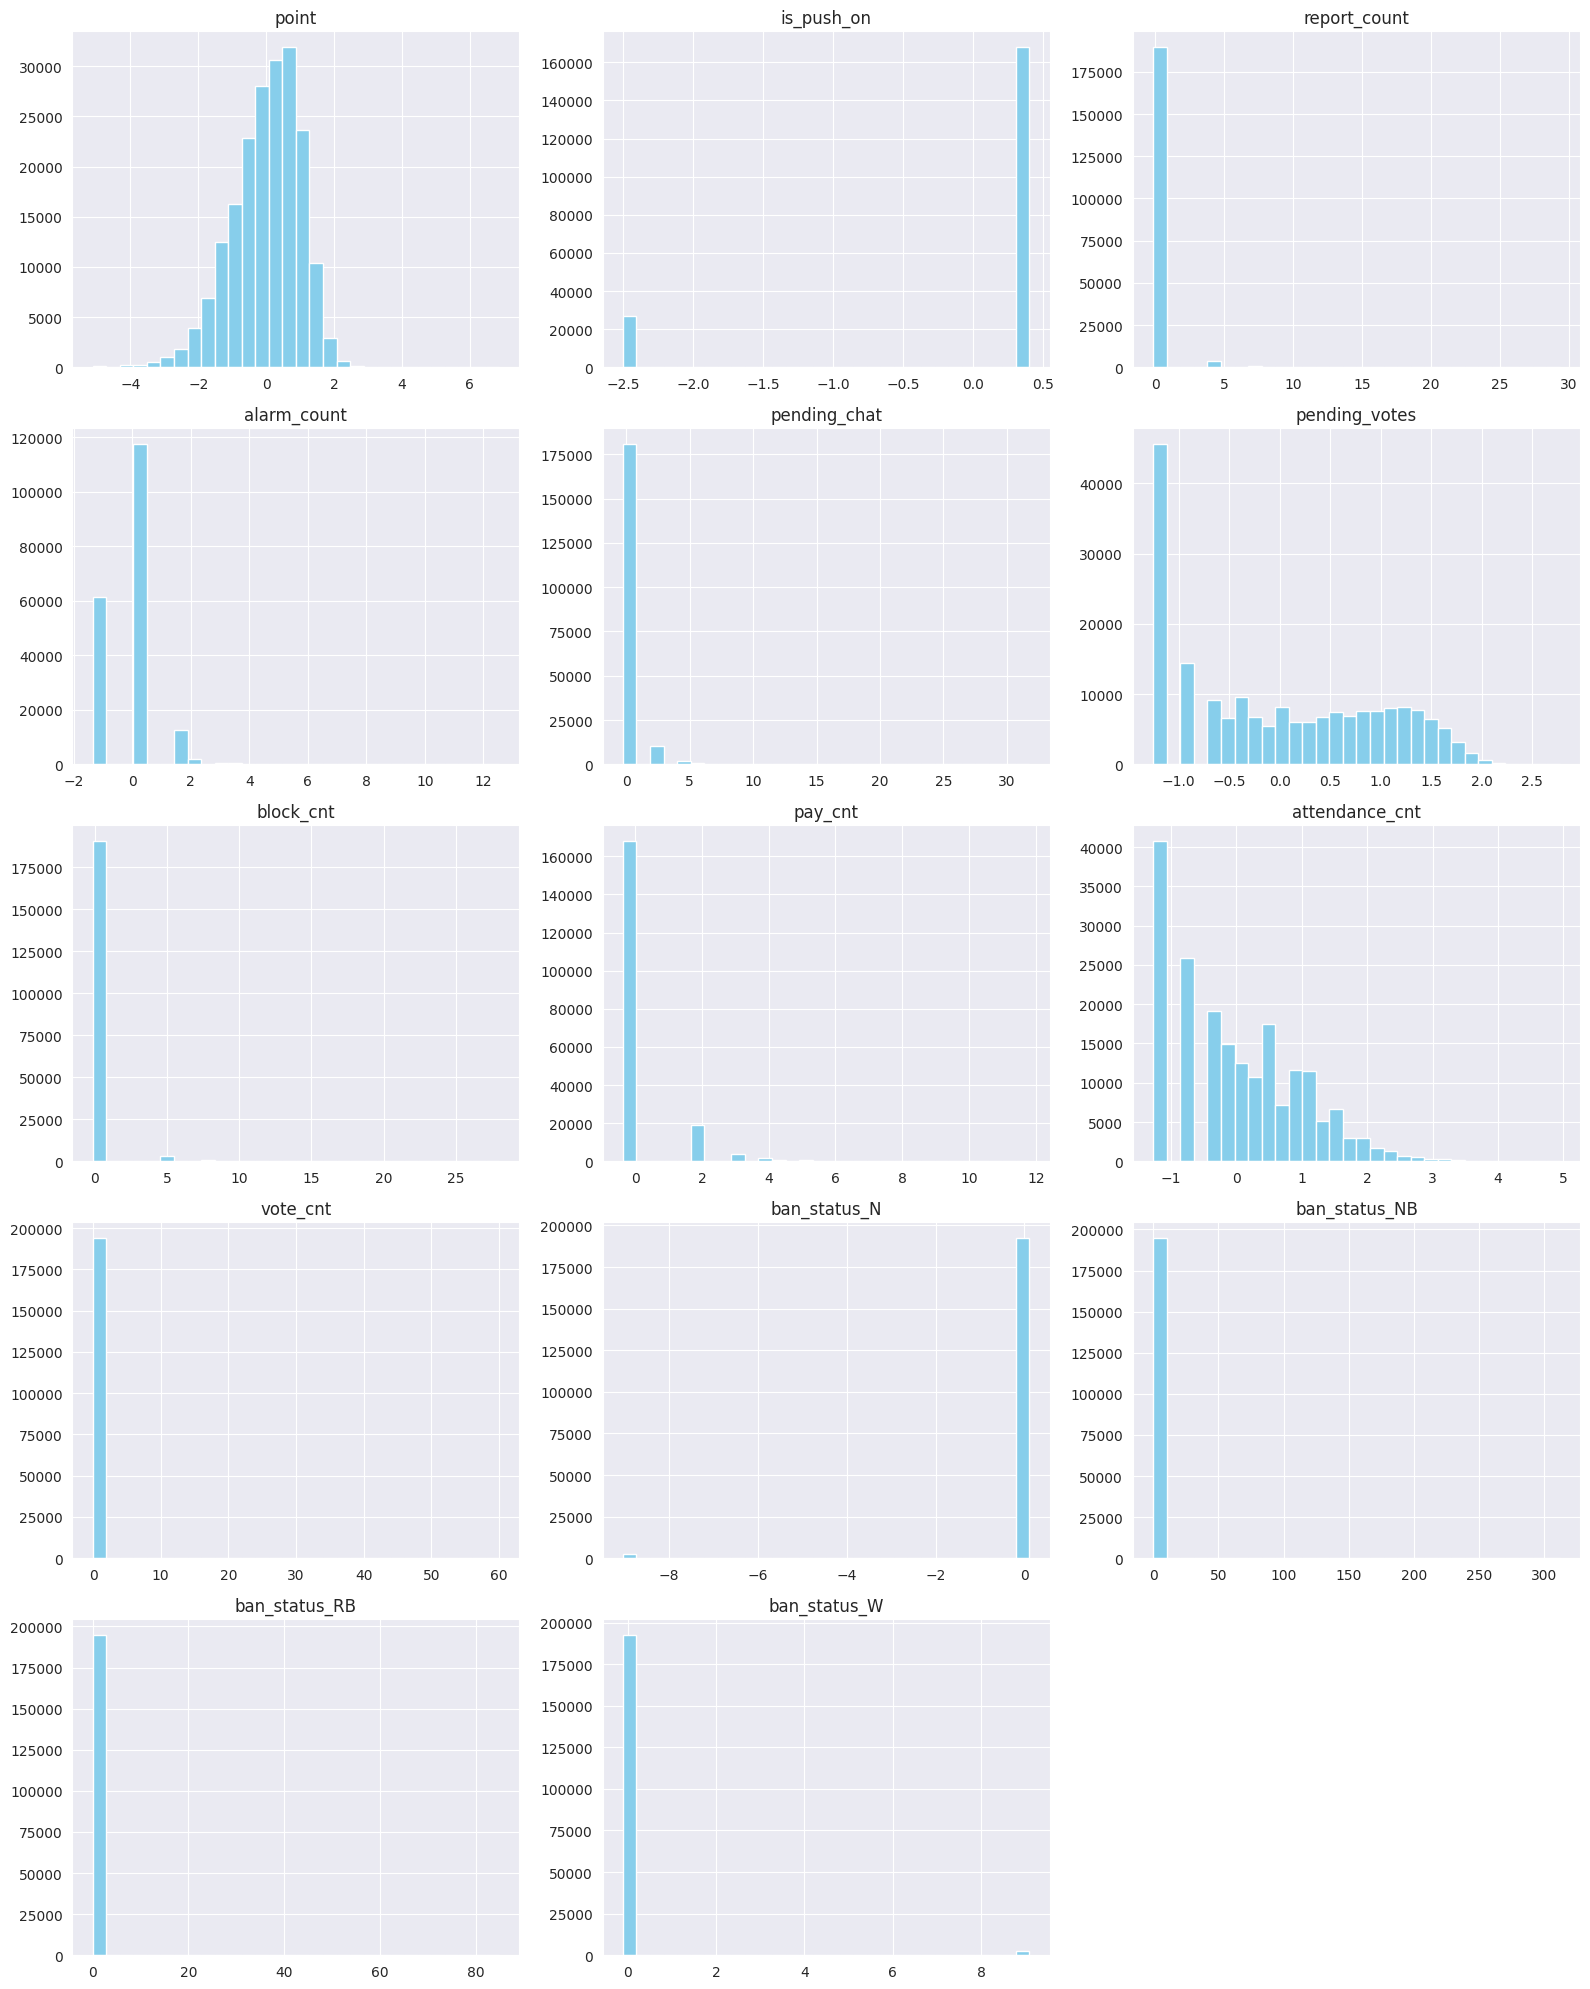

In [75]:
num_cols = scaled_df.select_dtypes(include=['float', 'int']).columns

# 한 행에 3개씩 뿌릴 subplot 크기 계산
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

for i, col in enumerate(num_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axes[row, col_idx].hist(scaled_df[col], bins=30, color='skyblue')    
    axes[row, col_idx].set_title(col)

# 빈 서브플롯은 감추기
for i in range(len(num_cols), n_rows * n_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axes[row, col_idx].axis('off')

plt.tight_layout()
plt.show()